In [16]:
import gymnasium as gym
import ale_py
# pip install ale-py

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import pickle
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import time
gym.register_envs(ale_py)

In [17]:
class Memory():
    def __init__(self, capacity, file=None):
        if file is not None:
            try:
                with open(file, "rb") as f:
                    d = pickle.load(f)
                    self.memory = d
            except Exception as e:
                self.memory = deque([], maxlen=capacity)
                print(e)
        else:
            self.memory = deque([], maxlen=capacity)

    def push(self, el):
        self.memory.append(el)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def to_list(self):
        return list(self.memory)

In [61]:
class DoubleConv(nn.Module):
    def __init__(self, channels, kernel, pool_kernel):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel)
        self.conv2 = nn.Conv2d(channels[1], channels[2], kernel)
        self.pool_kernel = pool_kernel

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, self.pool_kernel)
        return x

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        """
        self.double_conv1 = DoubleConv(channels=(3, 4, 8), kernel=(5,5), pool_kernel=(2,2))
        self.double_conv2 = DoubleConv(channels=(8, 8, 16), kernel=(5,5), pool_kernel=(3,3))
        """



        self.layer1 = nn.Linear(4, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 3)        

    def forward(self, x):
        """
        x = F.max_pool2d(x, (3,3))
        x = self.double_conv1(x)
        x = self.double_conv2(x)
        x = torch.flatten(x, x.dim()-3)
        x = torch.cat((x, f), x.dim()-1)
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


def optimize_model(optimizer, memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # state_batch = torch.tensor(np.array([state for (state, _, _, _, _, _) in transitions]), dtype=torch.float32)
    feature_batch = torch.tensor(np.array([f for (_, f, _, _, _, _) in transitions]), dtype=torch.float32)

    action_batch = torch.tensor([[action] for (_, _, action, _, _, _) in transitions])
    reward_batch =  torch.tensor([reward for (_, _, _, reward, _, _) in transitions])
    # next_state_batch = torch.tensor(np.array([s2 for (_, _, _, _, s2, _) in transitions]), dtype=torch.float32)
    next_feature_batch = torch.tensor(np.array([f for (_, _, _, _, _, f) in transitions]), dtype=torch.float32)



    state_qvalues = policy_net(feature_batch)
    state_action_values = state_qvalues.squeeze(1).gather(1, action_batch).squeeze(1)

    with torch.no_grad():
        next_qvalues = target_net(next_feature_batch).squeeze(1)
        next_state_values = next_qvalues.max(axis=1).values
        next_state_values = torch.tensor(next_state_values)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()

    loss = criterion(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

In [62]:
def truncate_picture(observation):
    return observation[40:180, 10:-10, :]

def find_pole_middle(observation):
    for i in range(observation.shape[0]):
        where = (observation[i, :, 0] < 100) & (observation[i, :, 1] < 100)
        blue_pixels = sum(where)
        if blue_pixels == 10:
            return (i, sum(np.where(where)[0])/10)
    return None

def find_player_pos(observation):
    for i in range(observation.shape[0]):
        where = (observation[i, :, 1] < 100) & (observation[i, :, 2] < 100)
        red_pixels = sum(where)
        if red_pixels > 0:
            return sum(np.where(where)[0])/red_pixels
    return None

def find_all_trees(observation):
    trees = []
    continous = False
    for i in range(observation.shape[0]):
        where = (observation[i, :, 0] < 100) & (observation[i, :, 2] < 100)
        green_pixels = sum(where)
        if green_pixels > 0 and not continous:
            continous = True
            trees.append((i, sum(np.where(where)[0])/green_pixels))
        if green_pixels == 0:
            continous = False
    return trees

In [69]:
def extract_extra_features(observation):
    pole = find_pole_middle(observation)
    player = find_player_pos(observation)
    if pole is not None:
        y_delta = pole[0] / observation.shape[0]
        x_delta = (pole[1]-player)/observation.shape[1]
    else:
        y_delta, x_delta = 1, 0
    trees = find_all_trees(observation)
    trees = [(y/observation.shape[0], (x-player)/observation.shape[1]) for (x,y) in trees]
    if len(trees) == 0:
        trees.append((1, 1))
    return [y_delta, x_delta, trees[0][0], trees[0][1]]

def get_reward(old_observation, current_observation):
    if old_observation.shape[0] == 3:
        old_observation = np.swapaxes(np.swapaxes(old_observation, 0, 1), 1, 2)
    if current_observation.shape[0] == 3:
        current_observation = np.swapaxes(np.swapaxes(current_observation, 0, 1), 1, 2)
    old_pole = find_pole_middle(old_observation)
    new_pole = find_pole_middle(current_observation)
    if new_pole is None or old_pole is None:
        return 0
    if new_pole[0] < old_pole[0]:
        return old_pole[0] - new_pole[0]
    return 0


In [70]:
def play_game(optimizer, memory, policy_net, target_net, MAX_ITER=1000):
    env = gym.make('ALE/Skiing-v5')
    obs, info = env.reset()
    obs = truncate_picture(obs)
    last_features = extract_extra_features(obs)
    obs = np.swapaxes(np.swapaxes(obs, 1, 2), 0, 1)
    done = False
    game_start = time.time()
    action_sum, action_cnt = 0, 0
    reward_sum = 0
    while not done and action_cnt < MAX_ITER:
        s = time.time()
        optimize_model(optimizer, memory, policy_net, target_net)
        if random.random() < EPSILON:
            """torch.tensor(obs, dtype=torch.float32),"""
            res = target_net(torch.tensor(last_features, dtype=torch.float32)).detach().numpy()
            action = np.argmax(res)
        else:
            action = int(random.random()*A)
        diff = time.time()-s
        action_sum += (diff)
        action_cnt += 1
        for _ in range(ACTION_REPETITION):
            observation, reward, done, trunc, info = env.step(action)
            if done:
                break
        observation = truncate_picture(observation)
        features = extract_extra_features(observation)
        observation = np.swapaxes(np.swapaxes(observation, 1, 2), 0, 1)
        reward = get_reward(obs, observation)
        reward_sum += reward
        memory.push((obs, last_features, action, reward, observation, features))
        obs = observation
        last_features = features

    print(f"Game done in {time.time()-game_start}s, avg it length {action_sum/action_cnt}, avg reward {reward_sum/action_cnt}")

    


In [72]:
BATCH_SIZE = 128
GAMMA = 0.95
TAU = 0.005
LR = 0.0005
EPSILON = 0.8
A = 3
MODEL_PATH = "./"
MEMORY_PATH = "./memory"
ACTION_REPETITION = 3


target_net = DQN()
# target_net.load_state_dict(torch.load(MODEL_PATH+"target", weights_only=True, map_location=torch.device('cpu')))
policy_net = DQN()
policy_net.load_state_dict(target_net.state_dict())
# policy_net.load_state_dict(torch.load(MODEL_PATH+"policy", weights_only=True, map_location=torch.device('cpu')))



memory = Memory(10**5, file=MEMORY_PATH)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

[Errno 2] No such file or directory: './memory'


In [73]:
while True:
    play_game(optimizer, memory, policy_net, target_net)
    torch.save(target_net.state_dict(), MODEL_PATH+"target")
    torch.save(policy_net.state_dict(), MODEL_PATH+"policy")
    with open(MEMORY_PATH, 'wb') as f:
        pickle.dump(memory.memory, f)

/tmp/ipykernel_75929/257553873.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state_values = torch.tensor(next_state_values)


Game done in 61.83828020095825s, avg it length 0.038051276683807374, avg reward 0.098
Game done in 38.389182567596436s, avg it length 0.024316603899002077, avg reward 0.956
Game done in 47.32132363319397s, avg it length 0.025647996425628664, avg reward 0.93
Game done in 44.82041835784912s, avg it length 0.022915493249893188, avg reward 1.576
Game done in 34.459447622299194s, avg it length 0.02418596751291421, avg reward 2.5594900849858355
Game done in 30.06349015235901s, avg it length 0.04219961419480115, avg reward 3.851380042462845
Game done in 31.595096826553345s, avg it length 0.031171949367958095, avg reward 3.1596091205211727
Game done in 59.17104911804199s, avg it length 0.0363554470539093, avg reward 0.841
Game done in 20.242595434188843s, avg it length 0.03586102779903359, avg reward 4.997245179063361


KeyboardInterrupt: 

Trees: [(137, 123.0)]


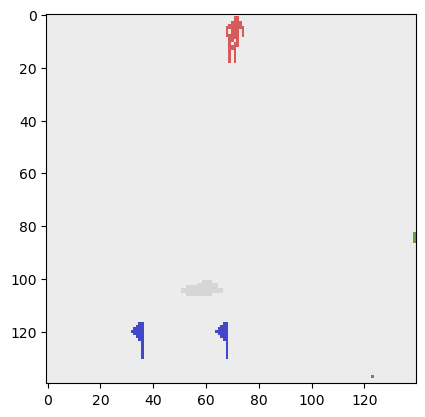

Pole: (116, 50.0)
Player: 71.5
Trees: [(133, 123.0)]
Reward: 4


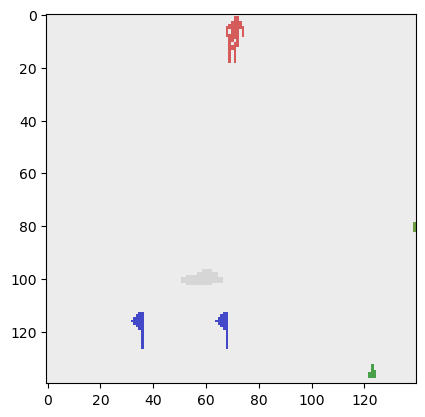

Pole: (111, 50.0)
Player: 71.5
Trees: [(128, 123.0)]
Reward: 5


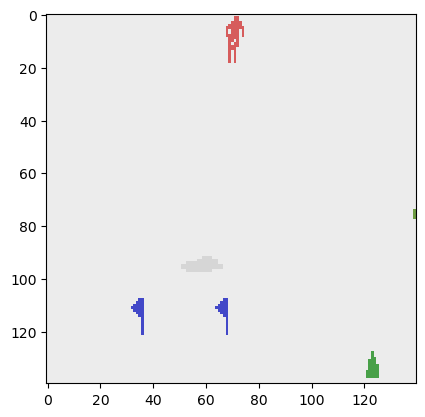

Pole: (105, 50.0)
Player: 71.5
Trees: [(122, 123.0)]
Reward: 6


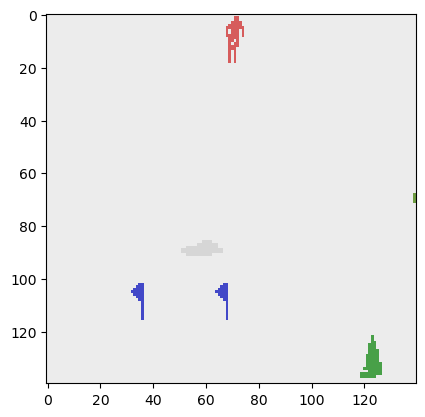

Pole: (96, 50.0)
Player: 71.5
Trees: [(113, 123.0)]
Reward: 9


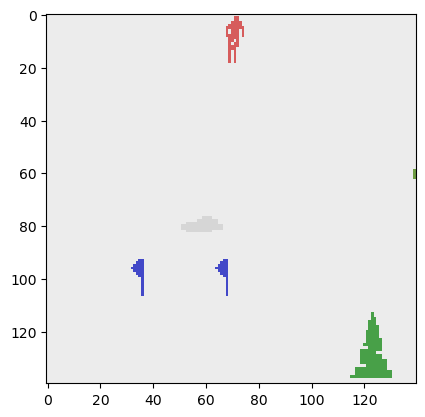

Pole: (87, 50.0)
Player: 71.5
Trees: [(104, 123.0)]
Reward: 9


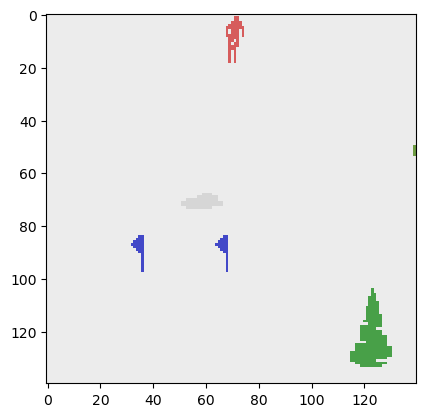

Pole: (77, 50.0)
Player: 71.5
Trees: [(94, 123.0)]
Reward: 10


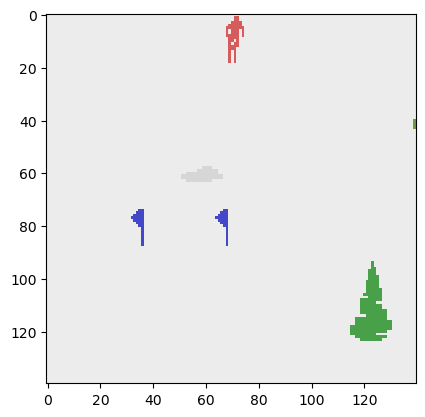

Pole: (67, 50.0)
Player: 71.5
Trees: [(84, 123.0)]
Reward: 10


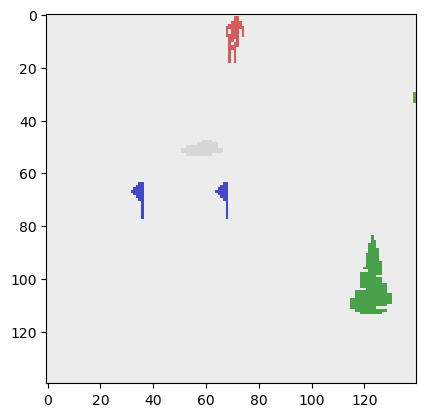

Pole: (56, 50.0)
Player: 71.5
Trees: [(73, 123.0)]
Reward: 11


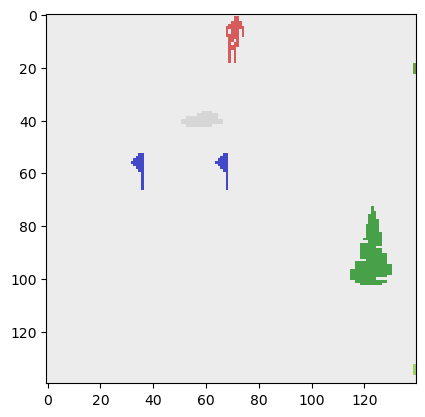

Pole: (42, 50.0)
Player: 71.5
Trees: [(59, 123.0)]
Reward: 14


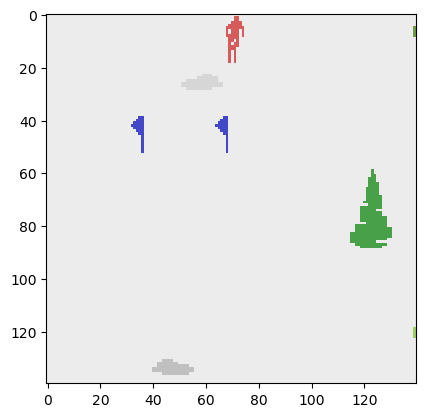

Pole: (29, 50.0)
Player: 71.5
Trees: [(46, 123.0)]
Reward: 13


In [74]:
env = gym.make('ALE/Skiing-v5')
env.reset()
observation, reward, done, trunc, info = env.step(0)
truncated_obs = observation[40:180, 10:-10, :]
plt.imshow(truncated_obs, interpolation="nearest")
print(f"Trees: {find_all_trees(truncated_obs)}")
old_observation = truncated_obs

for i in range(10):
    last_features = extract_extra_features(truncated_obs)
    res = target_net(torch.tensor(last_features, dtype=torch.float32)).detach().numpy()
    action = np.argmax(res)
    for j in range(ACTION_REPETITION):
        observation, reward, done, trunc, info = env.step(int())
    plt.imshow(truncated_obs, interpolation='nearest')
    plt.show()
    truncated_obs = truncate_picture(observation)
    print(f"Pole: {find_pole_middle(truncated_obs)}")
    print(f"Player: {find_player_pos(truncated_obs)}")
    print(f"Trees: {find_all_trees(truncated_obs)}")
    print(f"Reward: {get_reward(old_observation, truncated_obs)}")
    old_observation = truncated_obs
